Saving Dataset_completo.csv to Dataset_completo.csv
🎯 Features seleccionados: ['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'f0', 'Centroid', 'ZCR', 'spectral_rolloff', 'spectral_flatness', 'crest_factor', 'spectral_bandwidth', 'rms_energy']

 Reporte de Clasificación (Test):
              precision    recall  f1-score   support

           f       0.94      0.94      0.94        16
          mf       0.80      0.75      0.77        16
           p       0.78      0.82      0.80        17

    accuracy                           0.84        49
   macro avg       0.84      0.84      0.84        49
weighted avg       0.84      0.84      0.84        49



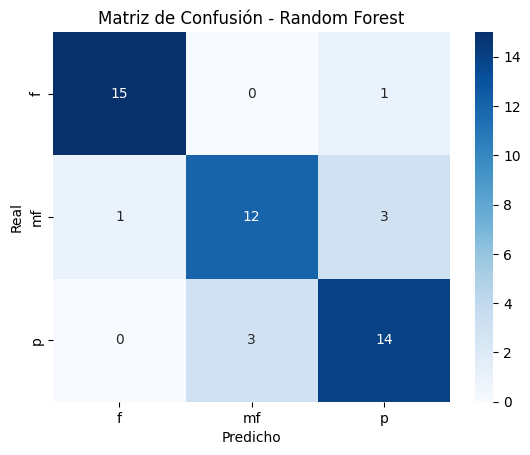


📈 Accuracy promedio (5-fold): 0.88 ± 0.05


In [1]:
# === 0. Subir CSV ===
from google.colab import files
uploaded = files.upload()

# === 1. Librerías ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

# === 2. Cargar dataset ===
# Reemplaza este nombre si tu archivo se llama distinto
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# === 3. Separar features y target ===
X = df.drop(columns=[
    "id_archivo", "nota", "octava", "simbolo_dinamica",
    "nombre_dinamica", "version", "clasificacion_duracion",
    "observacion_tecnica"
])
y = df["simbolo_dinamica"]

# === 4. Selección de 20 mejores features con escalado ===
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=20))
])

X_selected = pipeline.fit_transform(X, y)
selected_features = X.columns[pipeline.named_steps["select"].get_support()]
X_final = df[selected_features]

print("🎯 Features seleccionados:", list(selected_features))

# === 5. Separar train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

# === 6. Entrenar y evaluar Random Forest ===
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

# === 7. Reporte de clasificación ===
print("\n Reporte de Clasificación (Test):")
print(classification_report(y_test, y_pred))

# === 8. Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred, labels=clf_rf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=clf_rf.classes_, yticklabels=clf_rf.classes_)
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# === 9. Validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf_rf, X_final, y, cv=cv, scoring="accuracy")

print(f"\n📈 Accuracy promedio (5-fold): {scores.mean():.2f} ± {scores.std():.2f}")

# === 10. Importancia de features ===
clf_rf.fit(X_final, y)
importancias = clf_rf.feature_importances_

df_importancias = pd.DataFrame({
    "Feature": selected_features,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)


